# **Hotel Bookings**

# Introduction

### Problem
Dalam pemesanan hotel, pihak hotel ingin mendapatkan untung sebesar-besarnya dan rugi seminimal mungkin. Namun dalam praktiknya kerugian tidak dapat dihindarkan, salah satunya adalah dengan adanya pihak yang melakukan pembatalan hotel. Seperti keuntungan potensial yang harusnya didapat berkurang akibat ada pemesan yang membatalkan pemesanan, apalagi yang memesan dengan jumlah banyak atau kelompok.

### Goals
- Mampu memprediksi tamu yang akan melakukan pembatalan pesanan
- Melakukan strategi untuk mengurangi kerugian akibat dari pembatalan pesanan hotel
- Melakukan analisis mengenai customer behaviour

source and reference : 
- https://www.sciencedirect.com/science/article/pii/S2352340918315191
- https://www.kaggle.com/jessemostipak/hotel-booking-demand
- https://www.ezeeabsolute.com/blog/best-methods-to-increase-hotel-adr/?utm_source=KPIeBook&utm_medium=blog&utm_campaign=eABlog
- https://www.ezeeabsolute.com/blog/hotel-kpi/
- https://www.xotels.com/en/hotel-management/hotel-business-plan/

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import scipy.stats as ss

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
## Theils u
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

## Data Collection

In [3]:
df = pd.read_csv('hotel_bookings.csv')

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Describe Data and Columns

### *1. Summary Dataset*

In [5]:
df.shape

(119390, 32)

In [6]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [7]:
dfDesc = [] #mengetahui kolom pada dataset

for i in df.columns:
    dfDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / (len(df))) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [8]:
pd.DataFrame(dfDesc, columns = ['Data Features', 'Data Type', 'Null', 'Null (%)', 'Unique', 'Unique Sample'])

,Data Features,Data Type,Null,Null (%),Unique,Unique Sample
0,hotel,object,0,0.00,2,"[Resort Hotel, City Hotel]"
1,is_canceled,int64,0,0.00,2,"[0, 1]"
2,lead_time,int64,0,0.00,479,"[191, 162]"
3,arrival_date_year,int64,0,0.00,3,"[2016, 2017]"
4,arrival_date_month,object,0,0.00,12,"[October, April]"
5,arrival_date_week_number,int64,0,0.00,53,"[28, 9]"
6,arrival_date_day_of_month,int64,0,0.00,31,"[22, 12]"
7,stays_in_weekend_nights,int64,0,0.00,17,"[5, 18]"
8,stays_in_week_nights,int64,0,0.00,35,"[32, 22]"
9,adults,int64,0,0.00,14,"[20, 1]"


### *2. Describe perColumns*

In [9]:
df_cat = []
df_num = []

for i in df.columns:
    if df[i].dtypes == 'object':
        df_cat.append(i)
    else:
        df_num.append(i)

In [10]:
df_cat

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [11]:
df_num

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

#### - Hotel
Hotel merupakan jenis hotel

In [12]:
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

- Resort Hotel berada di resort region yaitu Algrave, Portugal
- City Hotel berada di city region yaitu Lisbon, Portugal

#### - is_canceled
Menandakan pembatalan pesanan

In [13]:
df['is_canceled'].unique()

array([0, 1], dtype=int64)

- 0 tidak melakukan pembatalan pemesanan
- 1 melakukan pembatala pemesanan

#### - Lead Time
Menandakan waktu interval antara pemesanan dengan kedatangan ke hotel

In [14]:
df['lead_time'].drop_duplicates().sample(5).values

array([  4, 317,  67, 229, 105], dtype=int64)

Terlihat bahwa jenis datanya merupakan numerikal dengan jenis kontinyu

#### - Arrival Date
Merupakan waktu kedatangan pemesan hotel

In [15]:
df['arrival_date_year'].unique()

array([2015, 2016, 2017], dtype=int64)

Terdapat 3 waktu historis transaksi pemesanan

In [16]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

Terdapat 12 bulan pemesanan historis

In [17]:
df['arrival_date_week_number'].nunique()

53

Terdapat 53 Minggu pemesanan historis

In [18]:
df['arrival_date_day_of_month'].nunique()

31

Terdapat 31 tanggal bergantung tiap bulan

In [19]:
df.groupby('arrival_date_year')['arrival_date_week_number'].nunique()

arrival_date_year
2015    27
2016    53
2017    35
Name: arrival_date_week_number, dtype: int64

In [20]:
df.groupby('arrival_date_year')['arrival_date_month'].nunique()

arrival_date_year
2015     6
2016    12
2017     8
Name: arrival_date_month, dtype: int64

Terlihat bahwa untuk tiap tahun historis transaksi berbeda atau mulainya berbeda, terlihat dari jumlah bulan yang tidak 12 bulan, serta jumlah minggu yang berbeda pada tiap tahunnya yang seharusnya berjumlah 53

In [21]:
df['days_in_waiting_list'].drop_duplicates().sample(5).values

array([ 11,  40, 215,  53, 178], dtype=int64)

Merupakan banyak hari yang ditunggu dari pemesanan hingga konfirmasi pemesanan ke pemesan

#### - Stays in Week
Jumlah menginap per-malam

In [22]:
df['stays_in_weekend_nights'].drop_duplicates().sample(5).values

array([16,  0,  8,  4, 13], dtype=int64)

In [23]:
df['stays_in_week_nights'].drop_duplicates().sample(5).values

array([6, 1, 8, 9, 5], dtype=int64)

Terlihat dengan berbagai macam data atau jumlah menginap yang tidak bisa di kategorikan atau merupakan numerikal

#### - Reservation
Pemesanan status dan tanggal

In [24]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

Dengan keterangan status pemesanan adalah :
- Check-Out merupakan pemesan yang sudah menggunakan kamar pesanan
- Canceled merupakan pemesan yang melakukan pembatalan
- No-Show merupakan pemesan yang tidak tau statusnya karena tidak membatalkan atau juga tidak check in

In [25]:
df['reservation_status_date'].drop_duplicates().sample(5).values

array(['2015-11-05', '2017-04-02', '2016-05-27', '2016-05-18',
       '2017-04-29'], dtype=object)

Merupakan tanggal saat status terakhir ditetapkan. Variabel ini dapat digunakan bersama dengan Reservation Status untuk memahami kapan pemesanan dibatalkan atau kapan pelanggan check-out dari hotel

#### - Person
Jumlah orang yang menginap dalam satu pemesanan

In [26]:
df['adults'].drop_duplicates().sample(5).values

array([ 2,  0, 27,  1, 20], dtype=int64)

In [27]:
df['children'].drop_duplicates().sample(5).values

array([10.,  1., nan,  2.,  3.])

In [28]:
df['babies'].drop_duplicates().sample(5).values

array([ 1,  9,  2, 10,  0], dtype=int64)

Terlihat untuk jenis kolom adults, children dan babies atau yang bisa dikatakan orang memiliki jenis numerikal karena jumlah seseorang yang hadir

#### - Meal
Jenis pemesanan makanan pada hotel

In [29]:
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

Dengan keterangan:
- Undefined/SC tidak memesan makanan (0 kali makan)
- BB memesan sarapan (1 kali makan)
- HB memesan sarapan dan makan siang / malam (2 kali makan)
- FB memesan sarapan, makan siang dan makan malam (3 kali makan)

#### - Country
Negara asal pemesanan hotel

In [30]:
df['country'].nunique()

177

Terdapat 177 jumlah negara yang memesan

#### - Segment

In [31]:
df['market_segment'].unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

Segmentasi pasar (Market Segment) adalah kegiatan membagi suatu pasar menjadi kelompok-kelompok pembeli yang berbeda yang memiliki kebutuhan, karakteristik, atau perilaku yang berbeda yang mungkin membutuhkan produk atau bauran pemasaran yang berbeda.
<p>sumber : https://id.wikipedia.org/wiki/Segmentasi_pasar </p>
    
Dengan keterangan data sebagai berikut :
- Direct adalah pembelian langsung di hotel
- Corporate
- Online TA
- Offline TA / TO
- Complementary
- Groups
- Undefined
- Aviation

In [32]:
df['distribution_channel'].unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

Dengan keterangan data sebagai berikut :
- Direct adalah pembelian langsung di hotel
- Corporate adalah 
- TA / TO
- Undefined
- GDS

In [33]:
df['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

Dengan keterangan tipe pemesan adalah :
- Transient merupakan tidak terikat dengan Contract, Group dan Transient-party
- Contract merupakan terikan dengan jaminan atau yang terkait dengan pemesan
- Transient-Party merupakan pemesanan sementara dan setidaknya terkait dengan Contract atau Grup
- Group merupakan terkait dengan sebuah kelompok

#### - Bookings History

In [34]:
df['is_repeated_guest'].unique()

array([0, 1], dtype=int64)

Dengan keterangan data sebagai berikut :
- 0 adalah tidak
- 1 adalah ya

In [35]:
df['previous_cancellations'].drop_duplicates().sample(5).values

array([ 6,  2, 21,  0, 19], dtype=int64)

Mengidentifikasi bahwa banyaknya jumlah pembatalan pemesanan sebelumnya

In [36]:
df['previous_bookings_not_canceled'].drop_duplicates().sample(5).values

array([16,  0, 43, 34, 57], dtype=int64)

Mengidentifikasi banyaknya jumlah pemesanan sebelumnya yang tidak dibatalkan

In [37]:
df['booking_changes'].drop_duplicates().sample(5).values

array([13,  8, 15,  2, 10], dtype=int64)

Mengidentifikasi banyaknya perubahan pemesanan

#### - Room Types

In [38]:
df['reserved_room_type'].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

Mengidentifikasi jenis kamar yang dipesan

In [39]:
df['assigned_room_type'].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'],
      dtype=object)

Mengidentifikasi jenis kamar yang ditempati

#### - Deposit

In [40]:
df['deposit_type'].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

Dengan keterangan data sebagai berikut :
- No Deposit adalah tidak memberikan uang jaminan atau deposit
- Refundable adalah memberikan uang ke pemesan yang membatalkan pesanan
- Non Refund adalah memberikan uang jaminan dan melakukan pembatalan uang tidak dikembalikan

#### - ID

In [41]:
df['agent'].drop_duplicates().sample(5).values

array([223., 214., 175., 431.,  68.])

Mengidentifikasi ID Travel agents yang melakukan pemesanan

In [42]:
df['company'].drop_duplicates().sample(5).values

array([348., 148., 465., 120., 487.])

Mengidentifikasi ID perusahaan yang melakukan pemesanan

#### - ADR
harga dari pemesanan

In [43]:
df['adr'].drop_duplicates().sample(5).values

array([ 57.28, 154.76, 198.77, 214.71, 162.14])

Merupakan tarif harian rata-rata seperti yang ditentukan dengan membagi jumlah semua transaksi penginapan dengan jumlah malam menginap

#### - Request
Permintaan dari tiap pemesan

In [44]:
df['required_car_parking_spaces'].drop_duplicates().sample(5).values

array([3, 8, 0, 1, 2], dtype=int64)

Merupakan jumlah tempat parkir setiap pemesanan

In [45]:
df['total_of_special_requests'].drop_duplicates().sample(5).values

array([3, 5, 0, 2, 1], dtype=int64)

Merupakan jumlah permintaan khusus dari pemesan seperti twin bed, lantai atas dan lain-lain

### *3. Handling Missing Values*

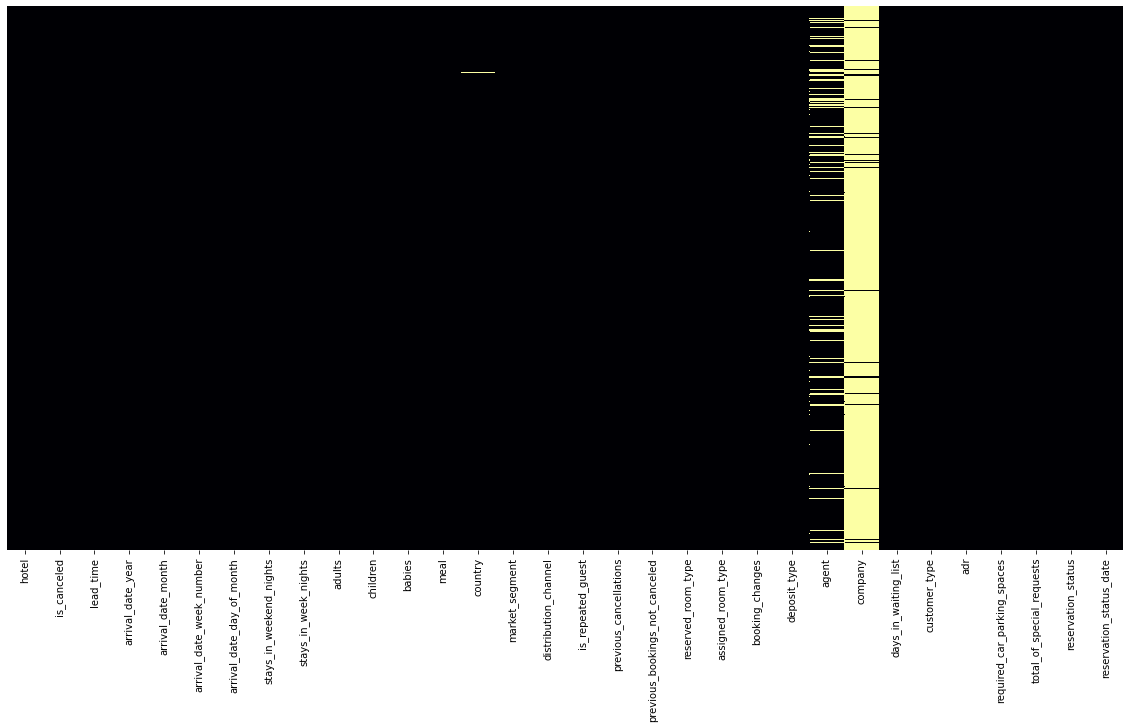

In [46]:
plt.figure(figsize=(20,10))

sns.heatmap(df.isna(), yticklabels=False, cmap='inferno', cbar=False)
plt.show()

In [47]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(f'{i}, null sebesar {round(df[i].isna().mean()*100,2)}%, total null {df[i].isna().sum()}')

children, null sebesar 0.0%, total null 4
country, null sebesar 0.41%, total null 488
agent, null sebesar 13.69%, total null 16340
company, null sebesar 94.31%, total null 112593


- Dapat diketahui terdapat 4 kolom yang memiliki null
- Melihat keterkaitan kolom tersebut dengan kolom lain sebelum di drop atau di isi
- memilih opsi antara mengisi atau menghapus nilai atau baris yang null

#### - Company

Company menandakan bahwa ID perusahaan yang memesankan transaksi, maka dari itu coba dengan melihat kondisi bahwa null merupakan transaksi tidak menggunakan company sedangkan yang terdapat ID menggunakan company

In [48]:
hn1 = df.copy()

In [49]:
hn1['company'] = hn1['company'].apply(lambda x: 0 if np.isnan(x) == True else 1)

In [50]:
len(hn1[hn1['company'] == 0])

112593

In [51]:
len(df[(df['company'].isnull() == True)])

112593

Sudah di cek dengan null sebelumnya menjadi 0 dan sama banyaknya jadi tidak ada error

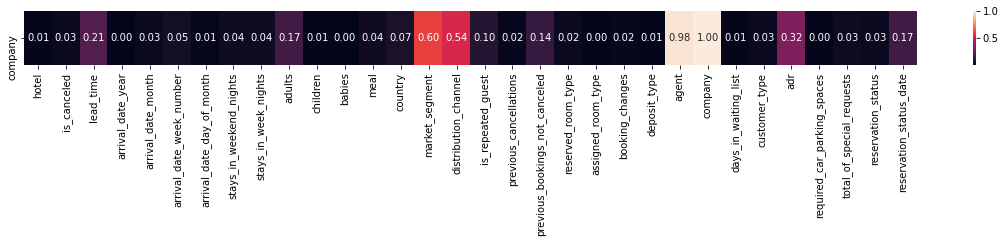

In [52]:
col = 'company'

theilu = pd.DataFrame(index=[col],columns=hn1.columns)
columns = hn1.columns
for j in range(0,len(columns)):
    u = theil_u(hn1[col].tolist(),hn1[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

#### - Agent

In [53]:
hn1['agent'] = hn1['agent'].apply(lambda x: 0 if np.isnan(x) == True else 1)

In [54]:
len(hn1[hn1['agent'] == 0])

16340

In [55]:
len(df[(df['agent'].isnull() == True)])

16340

Sudah di cek dengan null sebelumnya menjadi 0 dan sama banyaknya jadi tidak ada error

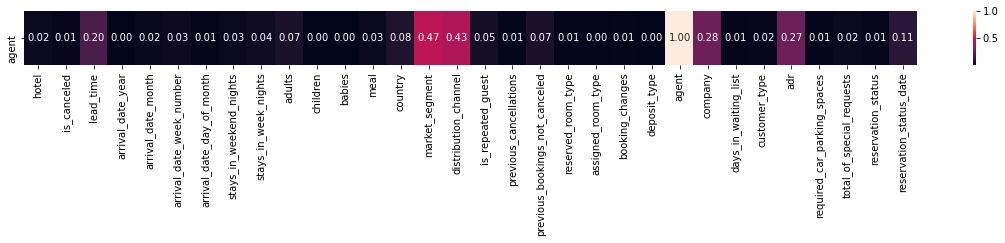

In [56]:
col = 'agent'

theilu = pd.DataFrame(index=[col],columns=hn1.columns)
columns = hn1.columns
for j in range(0,len(columns)):
    u = theil_u(hn1[col].tolist(),hn1[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

#### - Country

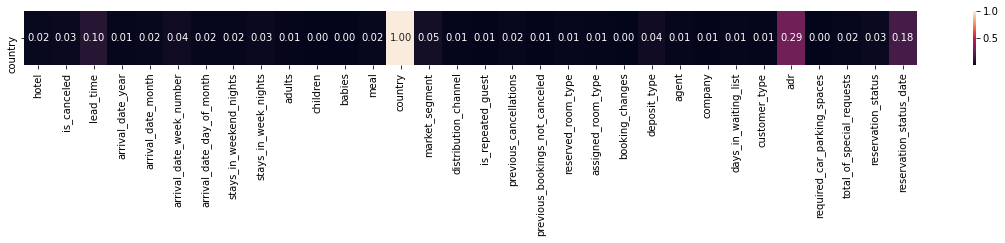

In [57]:
col = 'country'

theilu = pd.DataFrame(index=[col],columns=hn1.columns)
columns = hn1.columns
for j in range(0,len(columns)):
    u = theil_u(hn1[col].tolist(),hn1[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

Karena country tidak berkorelasi kuat dengan kolom apapun, maka fill na nya menggunakan teknik modus saja atau negara terbanyak yang melakukan reservasi

In [58]:
hn1['country'].mode()

0    PRT
dtype: object

In [59]:
hn1['country'].fillna('PRT', inplace=True)

#### - Children

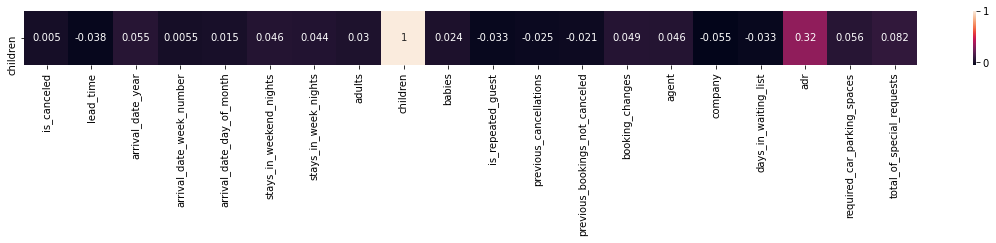

In [60]:
plt.figure(figsize=(20, 1))
sns.heatmap(hn1.corr().loc[['children'],:], annot=True)
plt.show()

In [61]:
len(hn1.dropna())/len(hn1)

0.9999664963564787

Karena jumlah null untuk children sangat kecil yaitu dibawah 0.00% maka dapat di hapus untuk data yang children nya null. Terlihat juga ketika di drop data masih sekitar 99.99%

#### - Checking Null

In [62]:
hn1 = hn1.dropna()

In [63]:
hn1.isnull().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
company                           False


Terlihat bahwa daataset sudah tidak memiliki null

In [64]:
hn1.to_csv('hotel_bookings_1.csv')